In [1]:
import time
import os
import random
import numpy as np                                                
import matplotlib.pyplot as plt                                   
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg    
                                                     
import gym
import gymnasium
from gymnasium import spaces


from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter

In [2]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor

In [3]:
from stable_baselines3.common.vec_env.base_vec_env import VecEnv, VecEnvStepReturn, VecEnvWrapper

In [4]:
from stable_baselines3.common.vec_env import SubprocVecEnv

Aim of the moddeling:

- if you want to train multiple envs at once e.g. to do multiple abstraction levels design between: comprehensive levels as per Bathe, or scale (micro, macro), or different optimization objectives, or different action space, you can use SB3 Vectorized Environments in the below manner. For instance, for two or more Env you can combine the reward in any specific way thus ensuring communication between the abstraction levels.
- This notebook aims at imitating simultaneous micro and macro topology optimisation. The micro element is either stretched or compressed at its boundaries at random imitating what would elements experience at microstructure.

In [5]:
y0, x0 = 5, 5

In [6]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
    return ObjectView(params)

def mbb_beam(width=y0, height=x0, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, -1, x] = 1
    normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[-1, rd, y] = -1
    return normals, forces, density

def mbb_beam_micro(width=y0, height=x0, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    
    normals[2, 1, x] = 1 #!!!!!!!!!!!!!!!!should be adjusted to account for any dimensions!!!!!!!!!!!!!!!!!!
    normals[2, 1, y] = 1 #!!!!!!!!!!!!!!!!should be adjusted to account for any dimension!!!!!!!!!!!!!!!!!!!
    normals[2, 3, x] = 1 #!!!!!!!!!!!!!!!!should be adjusted to account for any dimension!!!!!!!!!!!!!!!!!!!
    normals[2, 3, y] = 1 #!!!!!!!!!!!!!!!!should be adjusted to account for any dimension!!!!!!!!!!!!!!!!!!!
    
    forces = np.zeros((width + 1, height + 1, 2))
    
    a=random.choice([1,-1])
    b=random.choice([1,-1])
    
    for j in range(0, width):
        forces[0, j, y] = a
        forces[height, j, y] = -a 
        
    for j in range(0, height):
        forces[j, 0, x] = b
        forces[j, width, x] = -b
    
    
    return normals, forces, density

In [7]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [8]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [9]:
@autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)
autograd.extend.defvjp(gaussian_filter, _gaussian_filter_vjp)

In [10]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [11]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [12]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [13]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

@autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
                       lambda: print('err: gradient undefined'),
                       lambda: print('err: gradient not implemented'))

In [14]:
class Model:
    def __init__(self, x):
        self.flag_ = True
#         self.flag_ = False
        self.n, self.m = x.shape
        self.actions_dic={} 
    
        k=0
        for i in range(self.n):
            for j in range(self.m):
                self.actions_dic[k]=(i,j)
                k+=1
        
    def action_space_(self, action, X):
        x,y=self.actions_dic[action]
        X[x][y]=1
        
    def draw(self,X):  
        plt.figure(dpi=50) 
        print('\nFinal Cantilever beam design:')
        plt.imshow(X) 
        plt.show()

In [15]:
def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
#     constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [16]:
class CantileverEnv(gymnasium.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super().__init__()
        
        
        self.rd=0
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        DIM=self.args.nelx*self.args.nely
        N_DISCRETE_ACTIONS=self.args.nelx*self.args.nely
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        
 
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
        
    def step(self, action):
        
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        self.M.action_space_(action, self.x)
        
        tmp, const = fast_stopt(self.args, self.x)
        
        self.step_+=1
        
        self.reward+=(1/tmp)**2
       
        done=False
                  
        if self.step_>self.M.n*self.M.m:
            done=True
            
        if const>0.7:
            done=True
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
      
        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.reward, done,False, dict()

    def reset(self,seed=0):
        
        if not self.M.flag_:
            self.rd=random.choice([0,2,-2])
        else:
            self.rd=-1
           
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 

        self.reward=0
        self.needs_reset = False
        self.step_=0

        return self.x.reshape(self.x.shape[0]*self.x.shape[1]),{}

    def render(self, mode="human"):
        self.M.draw(self.x)    

    def close(self):
        pass

In [17]:
class CantileverEnvMicro(gymnasium.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super().__init__()
        
        
        self.rd=0
        self.args1 = get_args(*mbb_beam_micro(rd=self.rd))
        
        DIM=self.args1.nelx*self.args1.nely
        N_DISCRETE_ACTIONS=self.args1.nelx*self.args1.nely
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        
 
        self.x = anp.ones((self.args1.nely, self.args1.nelx))*self.args1.density 
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
        
    def step(self, action):
        
        self.args1 = get_args(*mbb_beam_micro(rd=self.rd))
        
        self.M.action_space_(action, self.x)
        
        tmp, const = fast_stopt(self.args1, self.x)
        
        self.step_+=1
        
        self.reward+=(1/tmp)**2
       
        done=False
                  
        if self.step_>self.M.n*self.M.m:
            done=True
            
        if const>0.7:
            done=True
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
      
        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.reward, done,False, dict()

    def reset(self,seed=0):
        
        if not self.M.flag_:
            self.rd=random.choice([0,2,-2])
        else:
            self.rd=-1
           
        self.x = anp.ones((self.args1.nely, self.args1.nelx))*self.args1.density 

        self.reward=0
        self.needs_reset = False
        self.step_=0

        return self.x.reshape(self.x.shape[0]*self.x.shape[1]),{}

    def render(self, mode="human"):
        self.M.draw(self.x)    

    def close(self):
        pass

In [18]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            
            
            
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
#             print(y)
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                
                mean_reward = np.mean(y[-100:])
                
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [19]:
# class TotalRewardVecWrapper(VecEnvWrapper):
#     def __init__(self, venv):
#         super().__init__(venv)

#     def step_wait(self):
#         obs, rewards, dones, infos = self.venv.step_wait()
# #         rewards[0] = 2*np.multiply(rewards[0],rewards[1])/(rewards[0] + rewards[1]) 
# #         total_reward = 2*np.multiply(*rewards)/np.sum(rewards)       
# #         rewards = np.full_like(rewards, total_reward)
#         return obs, rewards, dones, infos
    
#     def reset(self, seed=0):
#         obs = self.venv.reset()
#         return self.venv.reset() 

class SimpleEnvSwitcher(gymnasium.Env):
    def __init__(self, env1_id=CantileverEnv, env2_id=CantileverEnvMicro, switch_mode="alternate"):
        super().__init__()
        self.env1 = env1_id
        self.env2 = env2_id
        self.envs = [self.env1, self.env2]
        self.switch_mode = switch_mode
        self.current_idx = 0
        self.current_env = self.envs[self.current_idx]

        # Assume same observation and action space
        self.observation_space = self.env1.observation_space
        self.action_space = self.env1.action_space

    def reset(self, seed=0):
        if self.switch_mode == "alternate":
            self.current_idx = (self.current_idx + 1) % 2
        elif self.switch_mode == "random":
            self.current_idx = np.random.choice([0, 1])
        self.current_env = self.envs[self.current_idx]
        return self.current_env.reset()

    def step(self, action):
        return self.current_env.step(action)

    def render(self, mode="human"):
        return self.current_env.render(mode=mode)

    def close(self):
        self.env1.close()
        self.env2.close()


In [20]:
def draw(X):  
    plt.figure(dpi=50) 
    print('\nFinal Cantilever beam design:')
    plt.imshow(X.reshape(y0, x0)) 
    plt.show() 

In [21]:
ts=3e6

In [22]:
# Create log dir
log_dir = "/tmp/gym6_2o1o1kkkk/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env1 = CantileverEnv()
check_env(env1)

In [23]:
# Create and wrap the environment
env2 = CantileverEnvMicro()
check_env(env2)

In [24]:
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

In [25]:
# env = DummyVecEnv([lambda: env1, lambda: env2])

In [26]:
# env.spec = None

In [27]:
# Create and wrap the environment
# combined_venv = SimpleEnvSwitcher(env)

combined_venv  = DummyVecEnv([lambda: SimpleEnvSwitcher(env1, env2, switch_mode="alternate")])

# combined_venv = env
combined_venv  = VecMonitor(combined_venv , log_dir)

In [28]:
start=time.time()
model = PPO("MlpPolicy", combined_venv).learn(total_timesteps=ts, callback=callback)
end=time.time()  

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6_2o1o1kkkk/best_model.zip
Num timesteps: 2000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6_2o1o1kkkk/best_model.zip
Num timesteps: 3000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6_2o1o1kkkk/best_model.zip
Num timesteps: 4000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 5000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 6000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Saving new best model to /tmp/gym6_2o1o1kkkk/best_model.zip
Num timesteps: 7000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 8000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 9000
Best mean reward: 0.00 - Last mean reward per episode: 0.00
Num timesteps: 10000
Best mean reward: 0

Num timesteps: 91000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 92000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6_2o1o1kkkk/best_model.zip
Num timesteps: 93000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 94000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 95000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 96000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6_2o1o1kkkk/best_model.zip
Num timesteps: 97000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6_2o1o1kkkk/best_model.zip
Num timesteps: 98000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym6_2o1o1kkkk/best_model.zip
Num timesteps: 99000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 100000
Best mean

Num timesteps: 178000
Best mean reward: 0.03 - Last mean reward per episode: 0.02
Num timesteps: 179000
Best mean reward: 0.03 - Last mean reward per episode: 0.02
Num timesteps: 180000
Best mean reward: 0.03 - Last mean reward per episode: 0.02
Num timesteps: 181000
Best mean reward: 0.03 - Last mean reward per episode: 0.02
Num timesteps: 182000
Best mean reward: 0.03 - Last mean reward per episode: 0.02
Num timesteps: 183000
Best mean reward: 0.03 - Last mean reward per episode: 0.03
Num timesteps: 184000
Best mean reward: 0.03 - Last mean reward per episode: 0.03
Num timesteps: 185000
Best mean reward: 0.03 - Last mean reward per episode: 0.03
Saving new best model to /tmp/gym6_2o1o1kkkk/best_model.zip
Num timesteps: 186000
Best mean reward: 0.03 - Last mean reward per episode: 0.03
Num timesteps: 187000
Best mean reward: 0.03 - Last mean reward per episode: 0.03
Num timesteps: 188000
Best mean reward: 0.03 - Last mean reward per episode: 0.02
Num timesteps: 189000
Best mean reward

Num timesteps: 264000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Num timesteps: 265000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Num timesteps: 266000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Num timesteps: 267000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Num timesteps: 268000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Num timesteps: 269000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Saving new best model to /tmp/gym6_2o1o1kkkk/best_model.zip
Num timesteps: 270000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Num timesteps: 271000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Num timesteps: 272000
Best mean reward: 0.04 - Last mean reward per episode: 0.05
Saving new best model to /tmp/gym6_2o1o1kkkk/best_model.zip
Num timesteps: 273000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Saving new best model to /tmp/gym6_2o1o1kkkk/best_model.zip


Num timesteps: 347000
Best mean reward: 0.06 - Last mean reward per episode: 0.06
Saving new best model to /tmp/gym6_2o1o1kkkk/best_model.zip
Num timesteps: 348000
Best mean reward: 0.06 - Last mean reward per episode: 0.06
Num timesteps: 349000
Best mean reward: 0.06 - Last mean reward per episode: 0.06
Saving new best model to /tmp/gym6_2o1o1kkkk/best_model.zip
Num timesteps: 350000
Best mean reward: 0.06 - Last mean reward per episode: 0.06
Saving new best model to /tmp/gym6_2o1o1kkkk/best_model.zip
Num timesteps: 351000
Best mean reward: 0.06 - Last mean reward per episode: 0.06
Num timesteps: 352000
Best mean reward: 0.06 - Last mean reward per episode: 0.06
Saving new best model to /tmp/gym6_2o1o1kkkk/best_model.zip
Num timesteps: 353000
Best mean reward: 0.06 - Last mean reward per episode: 0.07
Saving new best model to /tmp/gym6_2o1o1kkkk/best_model.zip
Num timesteps: 354000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 355000
Best mean reward: 0.07

Num timesteps: 439000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 440000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 441000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 442000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 443000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 444000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 445000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 446000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 447000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 448000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 449000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 450000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 4

Num timesteps: 534000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 535000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 536000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 537000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 538000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 539000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 540000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 541000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 542000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 543000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 544000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 545000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 5

Num timesteps: 632000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 633000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 634000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 635000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 636000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 637000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 638000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 639000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 640000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 641000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 642000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 643000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 6

Num timesteps: 732000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 733000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 734000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 735000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 736000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 737000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 738000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 739000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 740000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 741000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 742000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 743000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 7

Num timesteps: 832000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 833000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 834000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 835000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 836000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 837000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 838000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 839000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 840000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 841000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 842000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 843000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 8

Num timesteps: 932000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 933000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 934000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 935000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 936000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 937000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 938000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 939000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 940000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 941000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 942000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 943000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 9

Num timesteps: 1032000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1033000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1034000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1035000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1036000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1037000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1038000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1039000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1040000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1041000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1042000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1043000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num 

Num timesteps: 1131000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1132000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1133000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1134000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1135000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1136000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1137000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1138000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1139000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1140000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1141000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1142000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num 

Num timesteps: 1230000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1231000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1232000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1233000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1234000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1235000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1236000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1237000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1238000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1239000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1240000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1241000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num 

Num timesteps: 1329000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1330000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1331000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1332000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1333000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1334000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1335000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1336000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1337000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1338000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1339000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1340000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num 

Num timesteps: 1428000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1429000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1430000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1431000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1432000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1433000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1434000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1435000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1436000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1437000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1438000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1439000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num 

Num timesteps: 1527000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1528000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1529000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1530000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1531000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1532000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1533000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1534000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1535000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1536000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1537000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1538000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num 

Num timesteps: 1626000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1627000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1628000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1629000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1630000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1631000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1632000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1633000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1634000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1635000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1636000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1637000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num 

Num timesteps: 1725000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1726000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1727000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1728000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1729000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1730000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1731000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 1732000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1733000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1734000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1735000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1736000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num 

Num timesteps: 1824000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1825000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1826000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1827000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1828000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1829000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1830000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1831000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1832000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1833000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1834000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1835000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num 

Num timesteps: 1923000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1924000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1925000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1926000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1927000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1928000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1929000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1930000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1931000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1932000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1933000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 1934000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num 

Num timesteps: 2022000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2023000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2024000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2025000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2026000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 2027000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 2028000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2029000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2030000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2031000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 2032000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 2033000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num 

Num timesteps: 2121000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 2122000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 2123000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 2124000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 2125000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 2126000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 2127000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 2128000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 2129000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 2130000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 2131000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num timesteps: 2132000
Best mean reward: 0.07 - Last mean reward per episode: 0.06
Num 

Num timesteps: 2220000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2221000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2222000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2223000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2224000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2225000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2226000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2227000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2228000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2229000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2230000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2231000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num 

Num timesteps: 2319000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2320000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2321000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2322000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2323000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2324000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2325000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2326000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2327000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2328000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2329000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2330000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num 

Num timesteps: 2417000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Saving new best model to /tmp/gym6_2o1o1kkkk/best_model.zip
Num timesteps: 2418000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2419000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2420000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2421000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2422000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2423000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2424000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2425000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2426000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2427000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2428000
Best

Num timesteps: 2514000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2515000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2516000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2517000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2518000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2519000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2520000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2521000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2522000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2523000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2524000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2525000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num 

Num timesteps: 2612000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2613000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2614000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2615000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2616000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2617000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2618000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2619000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2620000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2621000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2622000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2623000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num 

Num timesteps: 2709000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2710000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2711000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2712000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2713000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2714000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2715000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2716000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2717000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2718000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2719000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2720000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num 

Num timesteps: 2808000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2809000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2810000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2811000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2812000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2813000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2814000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2815000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2816000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2817000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2818000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2819000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num 

Num timesteps: 2907000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2908000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2909000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2910000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2911000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2912000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2913000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2914000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2915000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2916000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2917000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num timesteps: 2918000
Best mean reward: 0.07 - Last mean reward per episode: 0.07
Num 

In [29]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 55.75241861343384 min


In [30]:
obs=combined_venv.reset()

In [31]:
i=0
ans=[]
while i<1000:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = combined_venv.step(action)
    ans.append(obs)
    if any(dones):
        break
    
    i+=1


Final Cantilever beam design:


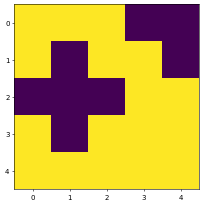

In [32]:
draw(ans[-2][0])

In [33]:
draw(ans[-2][1])

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/giga/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/6q/zp3bjthx3zv4n0bl2l835qdw0000gn/T/ipykernel_3931/445261690.py", line 1, in <module>
    draw(ans[-2][1])
IndexError: index 1 is out of bounds for axis 0 with size 1

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/giga/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/giga/Library/Python/3.9/lib/python/site-packages/IPython/core/ultratb.py", line 1428, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/Users/giga/Library/Python/3.9/lib/python/site-packages/IPython/core/ultratb.py", line 1319, in structured_traceback
    return VerboseTB.st

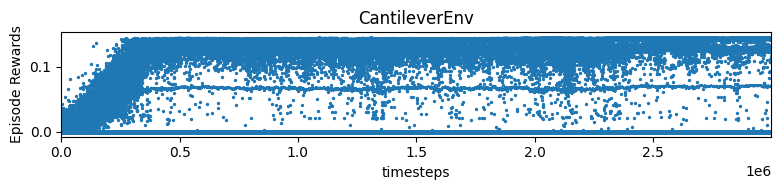

In [34]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "CantileverEnv")

In [35]:
obs=combined_venv.reset()

In [36]:
model_best = PPO.load(log_dir + "best_model.zip", env=combined_venv)

In [37]:
i=0
ans=[]
while i<1000:
    action, _states = model_best.predict(obs)
    obs, rewards, dones, info = combined_venv.step(action)
    ans.append(obs)
    if any(dones):
        break
    
    i+=1


Final Cantilever beam design:


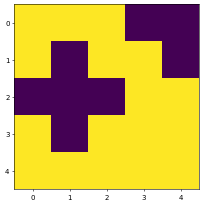

In [38]:
draw(ans[-2][0])

In [39]:
draw(ans[-2][1])

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/giga/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/6q/zp3bjthx3zv4n0bl2l835qdw0000gn/T/ipykernel_3931/445261690.py", line 1, in <module>
    draw(ans[-2][1])
IndexError: index 1 is out of bounds for axis 0 with size 1

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/giga/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/giga/Library/Python/3.9/lib/python/site-packages/IPython/core/ultratb.py", line 1428, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/Users/giga/Library/Python/3.9/lib/python/site-packages/IPython/core/ultratb.py", line 1319, in structured_traceback
    return VerboseTB.st